# Diabetic Retinopathy Detection

In this notebook we show how to use **Bayesian Deep Learning Benchmarks** (**`bdlb`**) for the binary high-resolution image classification Kaggle challenge [Diabetic Retinopathy Detection](https://www.kaggle.com/c/diabetic-retinopathy-detection), $y_{\text{target}} \in \{0,1\}$.

In [1]:
import os
pwd = os.path.abspath("../../")
from functools import partial

import numpy as np
# Use TensorFlow as an example,
# compatible with any other
# deep learning framework
import tensorflow as tf

# BDL Benchmarks framework
import bdlb

/home/scratch/miniconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


We store the hyperparameters (e.g., global variables) of the experiment in a global container. Feel free to tune and restart the notebook to see their impact on the final results.

In [2]:
def model_fn(features, labels, mode, params):
  inputs = features["image"]

  dropout_rate_conv = params["dropout_conv"]
  dropout_rate_dense = params["dropout_dense"]
  initial_conv_units = params["initial_conv_units"]
  dense_units = params["dense_units"]
  nr_of_dense_layers = params["nr_of_dense_layers"]
  initial_lr = params["initial_lr"]
  decay_rate = params["decay_rate"]
  batches_per_epoch = params["batches_per_epoch"]
  l2_reg = params["l2_reg"]

  l2regularization = tf.contrib.layers.l2_regularizer(l2_reg)

  if mode == tf.estimator.ModeKeys.EVAL or mode == tf.estimator.ModeKeys.PREDICT:
    apply_dropout = False
  else:
    apply_dropout = True

  leaky_relu = partial(tf.nn.leaky_relu, alpha=0.2)

  learning_rate = tf.train.exponential_decay(
      initial_lr,                # Base learning rate.
      tf.train.get_or_create_global_step(),  # Current index into the dataset.
      batches_per_epoch,          # Decay step.
      decay_rate,                # Decay rate.
      staircase=True)

  t = tf.layers.Conv2D(initial_conv_units, 3, strides=(2, 2), activation=leaky_relu, padding="same",
                       kernel_regularizer=l2regularization)(inputs)
  t = tf.layers.dropout(t, rate=dropout_rate_conv, training=apply_dropout)
  t = tf.layers.MaxPooling2D(pool_size=3, strides=(2, 2), padding="same")(t)

  t = tf.layers.Conv2D(initial_conv_units, 3, strides=(1, 1), activation=leaky_relu, padding="same",
                       kernel_regularizer=l2regularization)(t)
  t = tf.layers.dropout(t, rate=dropout_rate_conv, training=apply_dropout)
  t = tf.layers.Conv2D(initial_conv_units, 3, strides=(1, 1), activation=leaky_relu,
                       padding="same", kernel_regularizer=l2regularization)(t)
  t = tf.layers.dropout(t, rate=dropout_rate_conv, training=apply_dropout)
  t = tf.layers.MaxPooling2D(pool_size=3, strides=(2, 2), padding="same")(t)

  t = tf.layers.Conv2D(initial_conv_units * 2, 3, strides=(1, 1), activation=leaky_relu,
                       padding="same", kernel_regularizer=l2regularization)(t)
  t = tf.layers.dropout(t, rate=dropout_rate_conv, training=apply_dropout)
  t = tf.layers.Conv2D(initial_conv_units * 2, 3, strides=(1, 1), activation=leaky_relu,
                       padding="same", kernel_regularizer=l2regularization)(t)
  t = tf.layers.dropout(t, rate=dropout_rate_conv, training=apply_dropout)
  t = tf.layers.MaxPooling2D(pool_size=3, strides=(2, 2), padding="same")(t)

  t = tf.layers.Conv2D(initial_conv_units * 4, 3, strides=(1, 1), activation=leaky_relu,
                       padding="same", kernel_regularizer=l2regularization)(t)
  t = tf.layers.dropout(t, rate=dropout_rate_conv, training=apply_dropout)

  t = tf.layers.Conv2D(initial_conv_units * 4, 3, strides=(1, 1), activation=leaky_relu,
                       padding="same", kernel_regularizer=l2regularization)(t)
  t = tf.layers.dropout(t, rate=dropout_rate_conv, training=apply_dropout)

  t = tf.layers.Conv2D(initial_conv_units * 4, 3, strides=(1, 1), activation=leaky_relu,
                       padding="same", kernel_regularizer=l2regularization)(t)

  t = tf.layers.dropout(t, rate=dropout_rate_conv, training=apply_dropout)
  t = tf.layers.Conv2D(initial_conv_units * 4, 3, strides=(1, 1), activation=leaky_relu,
                       padding="same", kernel_regularizer=l2regularization)(t)
  t = tf.layers.dropout(t, rate=dropout_rate_conv, training=apply_dropout)
  t = tf.layers.MaxPooling2D(pool_size=3, strides=(2, 2), padding="same")(t)

  t = tf.layers.Conv2D(initial_conv_units * 8, 3, strides=(1, 1), activation=leaky_relu,
                       padding="same", kernel_regularizer=l2regularization)(t)
  t = tf.layers.dropout(t, rate=dropout_rate_conv, training=apply_dropout)

  t = tf.layers.Conv2D(initial_conv_units * 8, 3, strides=(1, 1), activation=leaky_relu,
                       padding="same", kernel_regularizer=l2regularization)(t)
  t = tf.layers.dropout(t, rate=dropout_rate_conv, training=apply_dropout)

  t = tf.layers.Conv2D(initial_conv_units * 8, 3, strides=(1, 1), activation=leaky_relu,
                       padding="same", kernel_regularizer=l2regularization)(t)
  t = tf.layers.dropout(t, rate=dropout_rate_conv, training=apply_dropout)

  t = tf.layers.Conv2D(initial_conv_units * 8, 3, strides=(1, 1), activation=leaky_relu,
                       padding="same", kernel_regularizer=l2regularization)(t)

  mean_pool = tf.keras.layers.GlobalAvgPool2D()(t)
  max_pool = tf.keras.layers.GlobalMaxPool2D()(t)

  t = tf.concat([mean_pool, max_pool], axis=1)

  for _ in range(nr_of_dense_layers):
    t = tf.layers.dropout(t, rate=dropout_rate_dense, training=apply_dropout)
    t = tf.layers.Dense(dense_units, activation=leaky_relu,
                        kernel_regularizer=l2regularization)(t)

  logits = tf.layers.Dense(1, kernel_regularizer=l2regularization)(t)

  if mode == tf.estimator.ModeKeys.PREDICT:
    predictions = {
        "label": tf.to_int64(tf.nn.sigmoid(logits) > 0.5),
        "probabilities": tf.nn.sigmoid(logits)
    }
    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=predictions,
        export_outputs={
            "classify": tf.estimator.export.PredictOutput(predictions)
        }
    )

  loss_vec = tf.nn.sigmoid_cross_entropy_with_logits(
      labels=tf.cast(labels, dtype=tf.float32), logits=logits)
  loss_ce = tf.reduce_mean(loss_vec)
  loss_reg = tf.losses.get_regularization_loss()
  loss = loss_ce + loss_reg
  pred_sig = tf.nn.sigmoid(logits)

  accuracy = tf.metrics.accuracy(
      labels=labels, predictions=tf.to_int64(pred_sig > 0.5)
  )
  accuracy_per_class = tf.metrics.mean_per_class_accuracy(
      labels=labels, predictions=tf.to_int64(pred_sig > 0.5), num_classes=2
  )
  loss_ce_mean = tf.metrics.mean(loss_ce)
  reg_loss_mean = tf.metrics.mean(loss_reg)
  auc = tf.metrics.auc(labels=labels, predictions=pred_sig)

  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.MomentumOptimizer(
        learning_rate, 0.9, use_nesterov=True)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
      optimize_op = optimizer.minimize(
          loss, tf.train.get_or_create_global_step())
    tf.summary.scalar("train_accuracy", accuracy[1])
    tf.summary.scalar("train_auc", auc[1])

    logging_hook = tf.train.LoggingTensorHook({"regularization_loss": reg_loss_mean[1],
                                               "cross_entropy_loss": loss_ce_mean[1],
                                               "accuracy": accuracy[1],
                                               "auc": auc[1],
                                               "per_class_accuracy": accuracy_per_class[1]}, every_n_iter=100)

    return tf.estimator.EstimatorSpec(
        mode=mode,
        loss=loss,
        train_op=optimize_op,
        training_hooks=[logging_hook]
    )

  if mode == tf.estimator.ModeKeys.EVAL:
    return tf.estimator.EstimatorSpec(
        mode=mode,
        loss=loss,
        eval_metric_ops={
            "accuracy": accuracy,
            "accuracy_per_class": accuracy_per_class,
            "auc": auc,
            "loss_cross_entropy": loss_ce_mean,
            "regularization_loss": reg_loss_mean,
        }
    )


## Initialize Downstream Task

**`bdlb`** provides three formats for the diabetic retinopathy detection benchmark:

* `DiabetesRealWorld`: The official full dataset (82 GB). This version is intended for the evaluation of proposed techniques at a scale applicable to the real world.
* `DiabetesMedium`: A subsampled version of the full dataset (~33 GB). This version is intended for prototyping and cases where larger data renders proposed techniques computationally infeasible.
* `DiabetesToy`: A simple experiment (~130 MB) based on the feature vectors
$$\{x_{n}\}_{n=1}^{N}, \quad x_{n} \in \mathbb{R}^{512}$$
extracted from a fully-trained VGG16 neural network on the same task. This version is intended for sanity checks and debugging only.

In the interest of quick reproducability of the results of this notebook, we will use the `DiabetesToy` format, which can be easily replaced in one line with any of the other two formats, provided that the data are properly fetched and stored locally and an appropriate model is designed.

In [3]:
dtask = bdlb.tasks.DiabetesMedium(os.path.join(pwd, "data/diabetes"))

## Initialize Model

For the Diabetic Retinopathy Detection benchmark we provide baseline implementations for:

* Dropout as a Bayesian approximation [[1](#Yarin-2015)]
* Mean Field Variational Inference [[2](#Peterson-1987)]

In this notebook we implement a single layer neural network (`sigmoid` output activation), trained according to [[1](#Yarin-2015)].

In [4]:
BATCH_SIZE = 64
batches_per_epoch = dtask.train_ds.y.size // BATCH_SIZE
tf.logging.set_verbosity(tf.logging.INFO)

# Set model dir where to save checkpoints and report
model_dir = os.path.join(pwd, "tmp/models/diabetes/medium/deterministic_tf")

# Some TF settings
session_config = tf.ConfigProto()
session_config.gpu_options.allow_growth = True
estimator_config = tf.estimator.RunConfig(session_config=session_config)

# Create TF estimator
classifier = tf.estimator.Estimator(
    model_fn=model_fn,
    model_dir=model_dir,
    config=estimator_config,
    params={
        "dropout_conv": 0.1,
        "dropout_dense": 0.2,
        "initial_conv_units": 16,
        "dense_units": 512,
        "nr_of_dense_layers": 0,
        "initial_lr": 0.05,
        "decay_rate": 0.98,
        "batches_per_epoch": batches_per_epoch,
        "l2_reg": 5e-5
    }
)

INFO:tensorflow:Using config: {'_model_dir': '/scratch/21122018/bdlb_private/tmp/models/diabetes/medium/deterministic_tf', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': gpu_options {
  allow_growth: true
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa512c716d8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Training & Evaluation Loop

In [5]:
classifier.evaluate(input_fn=dtask.validate_tf_input_fn(batch_size=BATCH_SIZE, nb_workers=20))

Instructions for updating:
Use `tf.data.experimental.map_and_batch(...)`.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-27-20:01:59
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /scratch/21122018/bdlb_private/tmp/models/diabetes/medium/deterministic_tf/model.ckpt-51500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-27-20:02:02
INFO:tensorflow:Saving dict for global step 51500: accuracy = 0.72433037, accuracy_per_class = 0.72461045, auc = 0.8132622, global_step = 51500, loss = 0.5953666, loss_cross_entropy = 0.57806283, regularization_loss = 0.017303962
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 51500: /scratch/21122018/bdlb_private/tmp/models/diabetes/medium/deterministic_tf/model.ckpt-51500


{'accuracy': 0.72433037,
 'accuracy_per_class': 0.72461045,
 'auc': 0.8132622,
 'global_step': 51500,
 'loss': 0.5953666,
 'loss_cross_entropy': 0.57806283,
 'regularization_loss': 0.017303962}

## Uncertainty Estimator

In [6]:
# Create estimator that takes images and produces prediction and uncertainties
external_batch_size = 1000  # Number of images to give to estimator at once

def predict(images):
    """Uncertainty estimator function.
    Args:
        x: Input features, `NumPy` array.
    Returns:
        mean: Predictive mean.
        uncertainty: Uncertainty in prediction.
    """
    images = images.astype(np.float32)

    input_fun = tf.estimator.inputs.numpy_input_fn(
        {"image": images},
        None,
        batch_size=external_batch_size,
        num_epochs=1,
        shuffle=False,
        num_threads=1
    )

    mc_preds = np.array(
        list(map(lambda x: x["probabilities"], classifier.predict(input_fn=input_fun))))
    mc_preds = mc_preds.reshape((-1, external_batch_size))

    _MC_samples = np.concatenate([1. - mc_preds[:, :, None], mc_preds[:, :, None]], -1)
    expected_p = np.mean(_MC_samples, axis=0)
    entropy_expected_p = - np.sum(expected_p * np.log(expected_p + 1e-10), axis=-1)

    return mc_preds.mean(axis=0), entropy_expected_p

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /scratch/21122018/bdlb_private/tmp/models/diabetes/medium/deterministic_tf/model.ckpt-51500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /scratch/21122018/bdlb_private/tmp/models/diabetes/medium/deterministic_tf/model.ckpt-51500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph wa

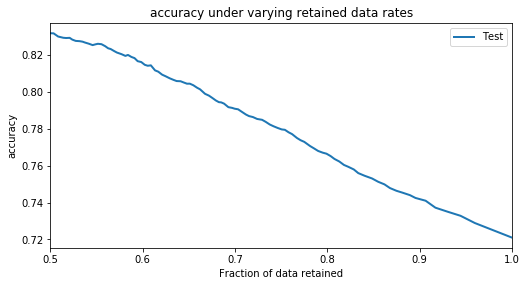

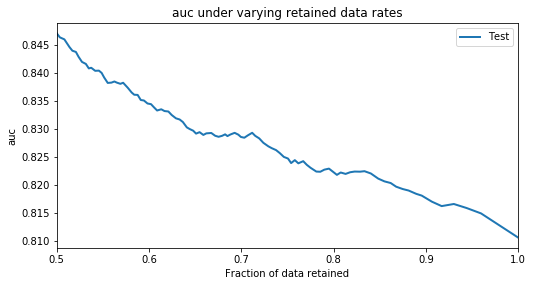

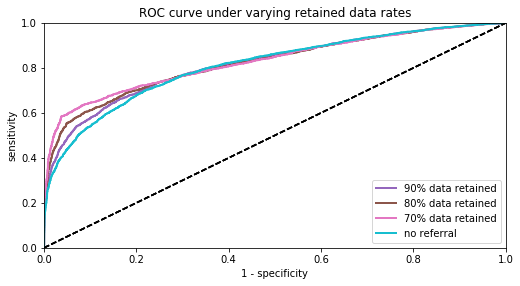

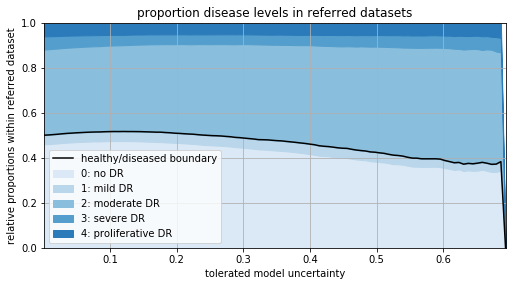

In [7]:
report = dtask.generate_report(predict, batch_size=external_batch_size)
tex = report.to_latex(output_file=os.path.join(pwd, "tmp/results/diabetes/medium/deterministic_tf/report.tex"),
                      title="Diabetes medium benchmark with Deterministic baseline")
# Raw LaTeX report
print(tex)

<a name="Yarin-2015">[1]</a> Yarin Gal and Zoubin Ghahramani. _Dropout as a Bayesian approximation: Representing model uncertainty in deep learning_. arXiv:1506.02142, 2015.

<a name="Peterson-1987">[2]</a> Peterson, C. and Anderson, J. _A mean field theory learning algorithm for neural networks_. Complex Systems, 1(5):995–1019, 1987.

<a name="Leibig-2017">[3]</a> Christian Leibig, Vaneeda Allken, Murat Seçkin Ayhan, Philipp Berens, and Siegfried Wahl. Leveraging uncertainty information from deep neural networks for disease detection.Nature, 7(1):17816, 2017.